In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import ast
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
import warnings
warnings.filterwarnings('ignore')
from src import utils_HydroWaste as utils

In [2]:
orange_color = "#ea801c"
blue_color = "#1a80bb"
green_color = "#6abf69"
state_name_abbrev_pair = utils.state_name_abbrev_pair()

## Read Data

In [3]:
df_hw_us = utils.read_HydroWaste_data(
    HydroWaste_path="../HydroWASTE_v10/HydroWASTE_v10.csv",
    us_boundary_path="../HydroWASTE_v10/US_State_Boundaries",
)
df_hw_us.head()

,hw_WWTP_NAME,hw_lat,hw_lon,state,geometry
0,AKRON LAGOON,32.886,-87.740,Alabama,POINT (-87.74000 32.88600)
1,ALABASTER WWTP,33.253,-86.815,Alabama,POINT (-86.81500 33.25300)
2,ALEXANDER CITY SUGAR CREEK WWTP,32.901,-85.951,Alabama,POINT (-85.95100 32.90100)
3,ALEXANDER CITY COLEY CREEK WWTP,32.930,-85.882,Alabama,POINT (-85.88200 32.93000)
4,ALTOONA LAGOON,34.038,-86.332,Alabama,POINT (-86.33200 34.03800)


In [4]:
osm_us = utils.read_osm_data(osm_path="../WWTP_list_all_state/WWTP_all_states.csv")
osm_CA = utils.read_osm_data(osm_path="../gdf_CA_Yes_and_Maybe.csv").drop(
    columns=["Unnamed: 0"]
)
osm_TX = utils.read_osm_data(osm_path="../gdf_texas_Yes_and_Maybe.csv").drop(
    columns=["Unnamed: 0"]
)

## World Map Plot

In [5]:
us_boundary = gpd.read_file("../HydroWASTE_v10/US_State_Boundaries")

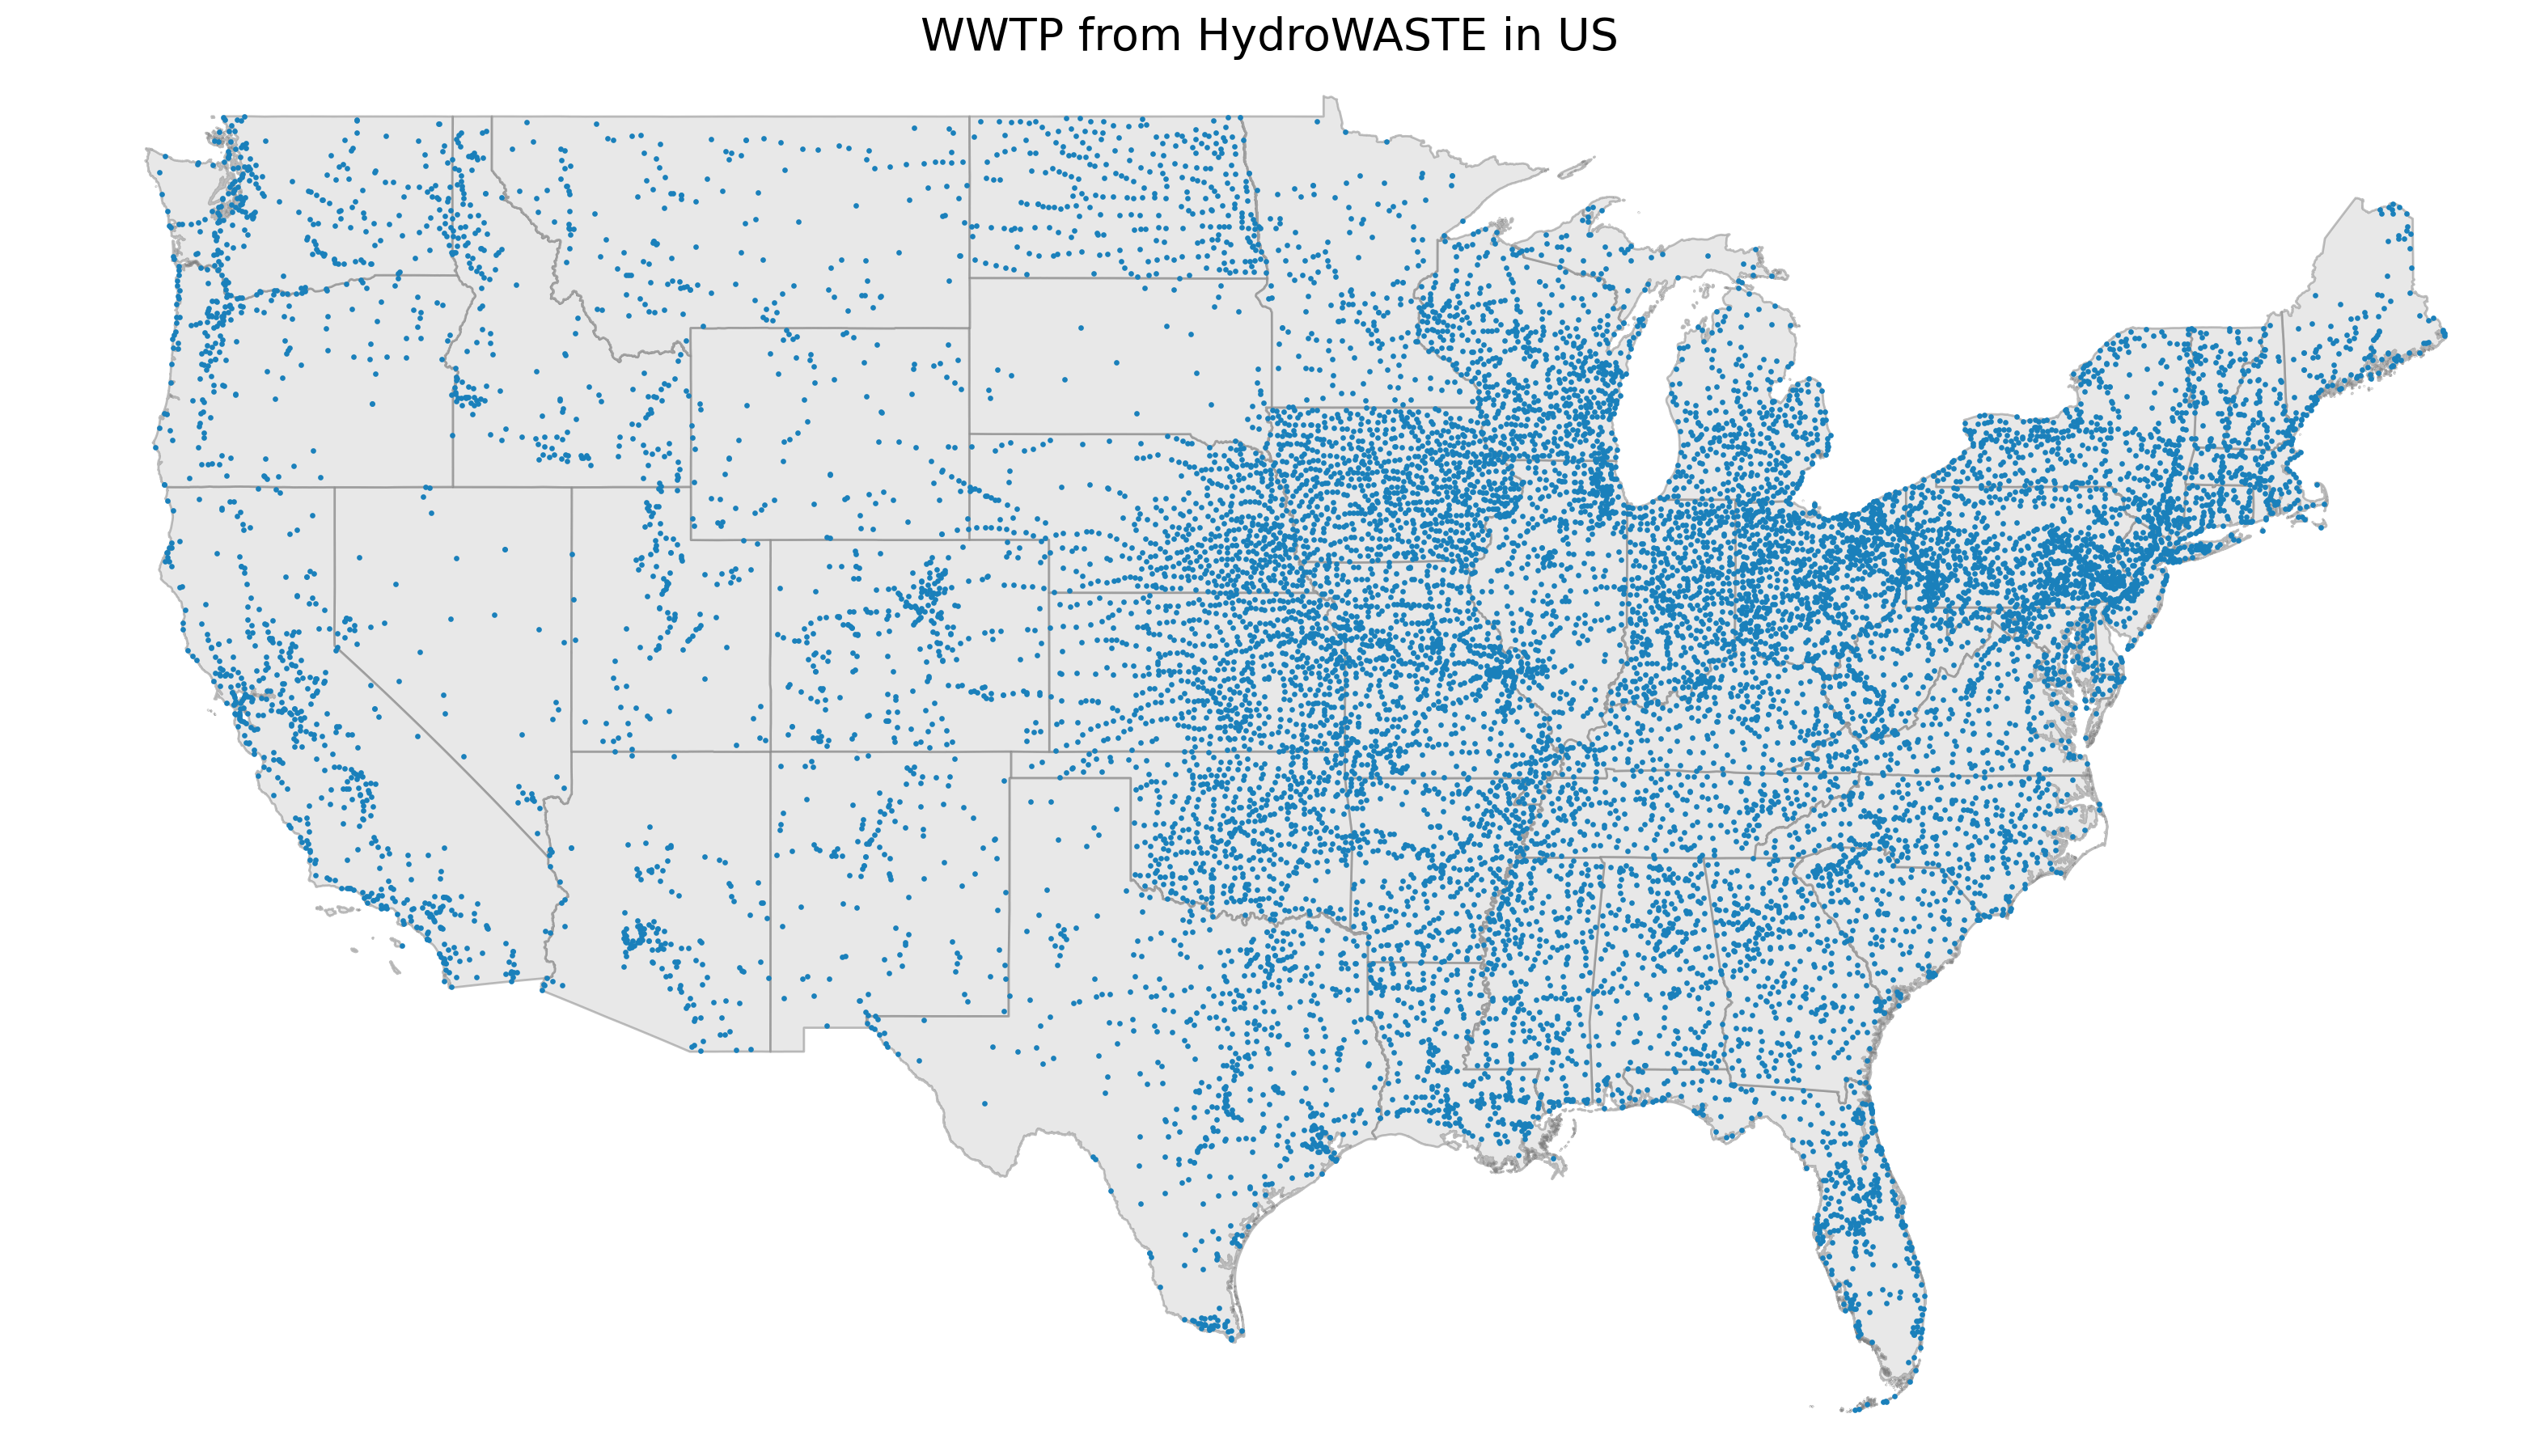

In [6]:
utils.plt_world_map(
    df_hw_us, us_boundary, title="WWTP from HydroWASTE in US", color=blue_color
)

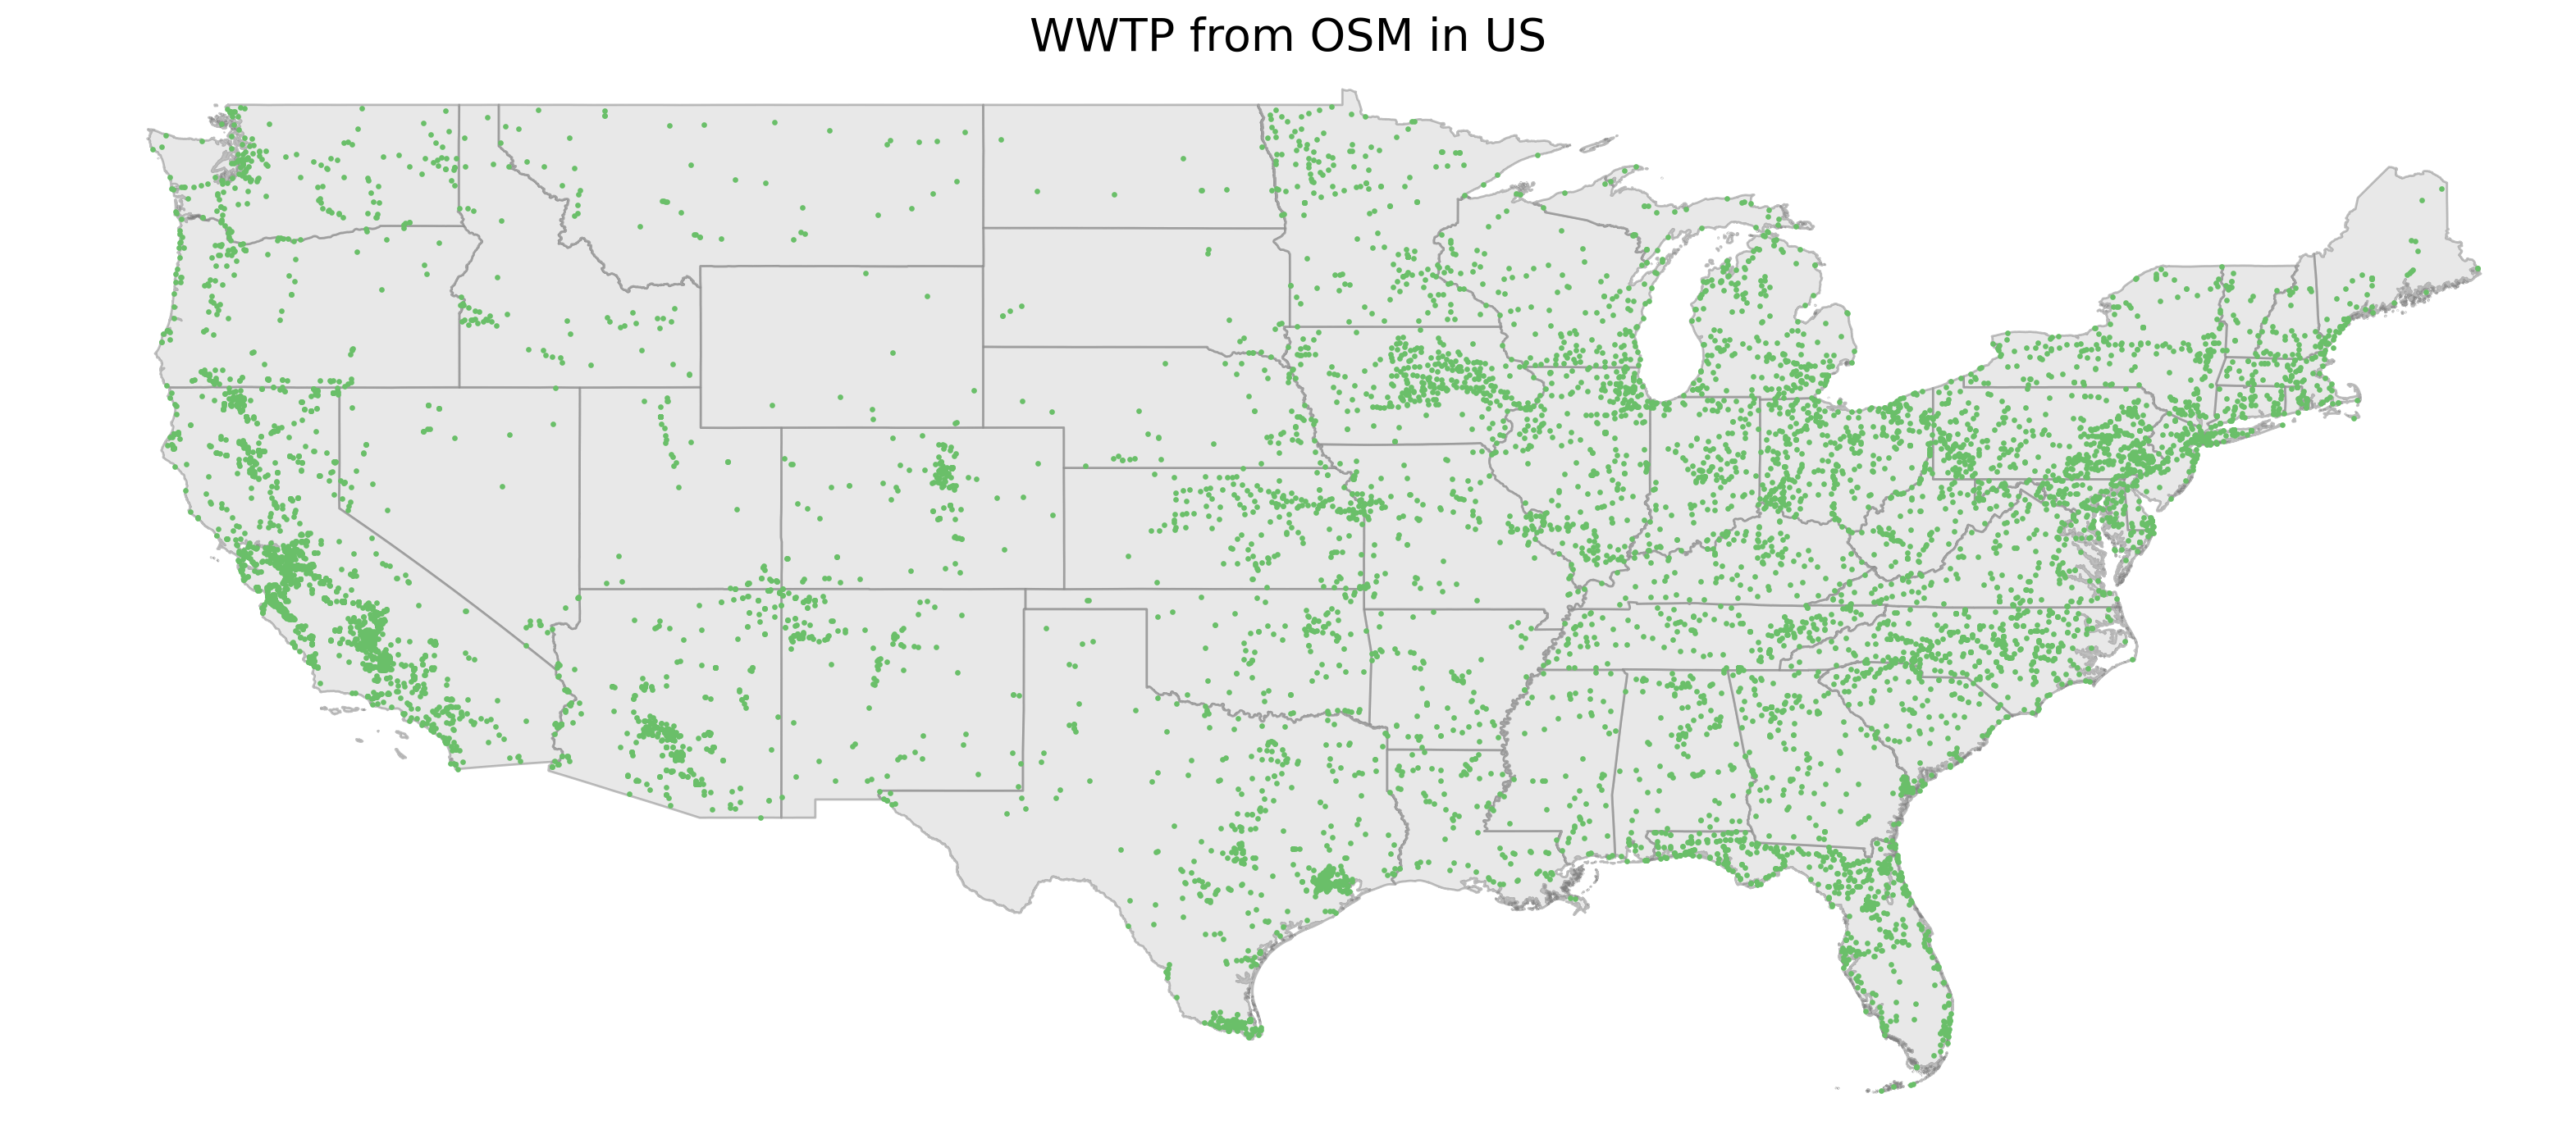

In [7]:
gdf_osm = gpd.GeoDataFrame(
    osm_us, geometry=gpd.points_from_xy(osm_us["osm_longitude"], osm_us["osm_latitude"])
)
utils.plt_world_map(
    gdf_osm, us_boundary, title="WWTP from OSM in US", color=green_color
)

## Plot State-by-State WWTP number from HydroWaste and OSM

Number of WWTPs in the US from HydroWASTE:  14748
Number of WWTPs in the US from osm:  11282
Number of state where HydroWASTE has more WWTPs:  40
State where HydroWASTE has more WWTPs:  ['AL' 'AR' 'CA' 'CO' 'CT' 'GA' 'ID' 'IL' 'IN' 'IA' 'KS' 'KY' 'LA' 'ME'
 'MD' 'MA' 'MI' 'MS' 'MO' 'MT' 'NE' 'NH' 'NJ' 'NY' 'ND' 'OH' 'OK' 'OR'
 'PA' 'SC' 'SD' 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


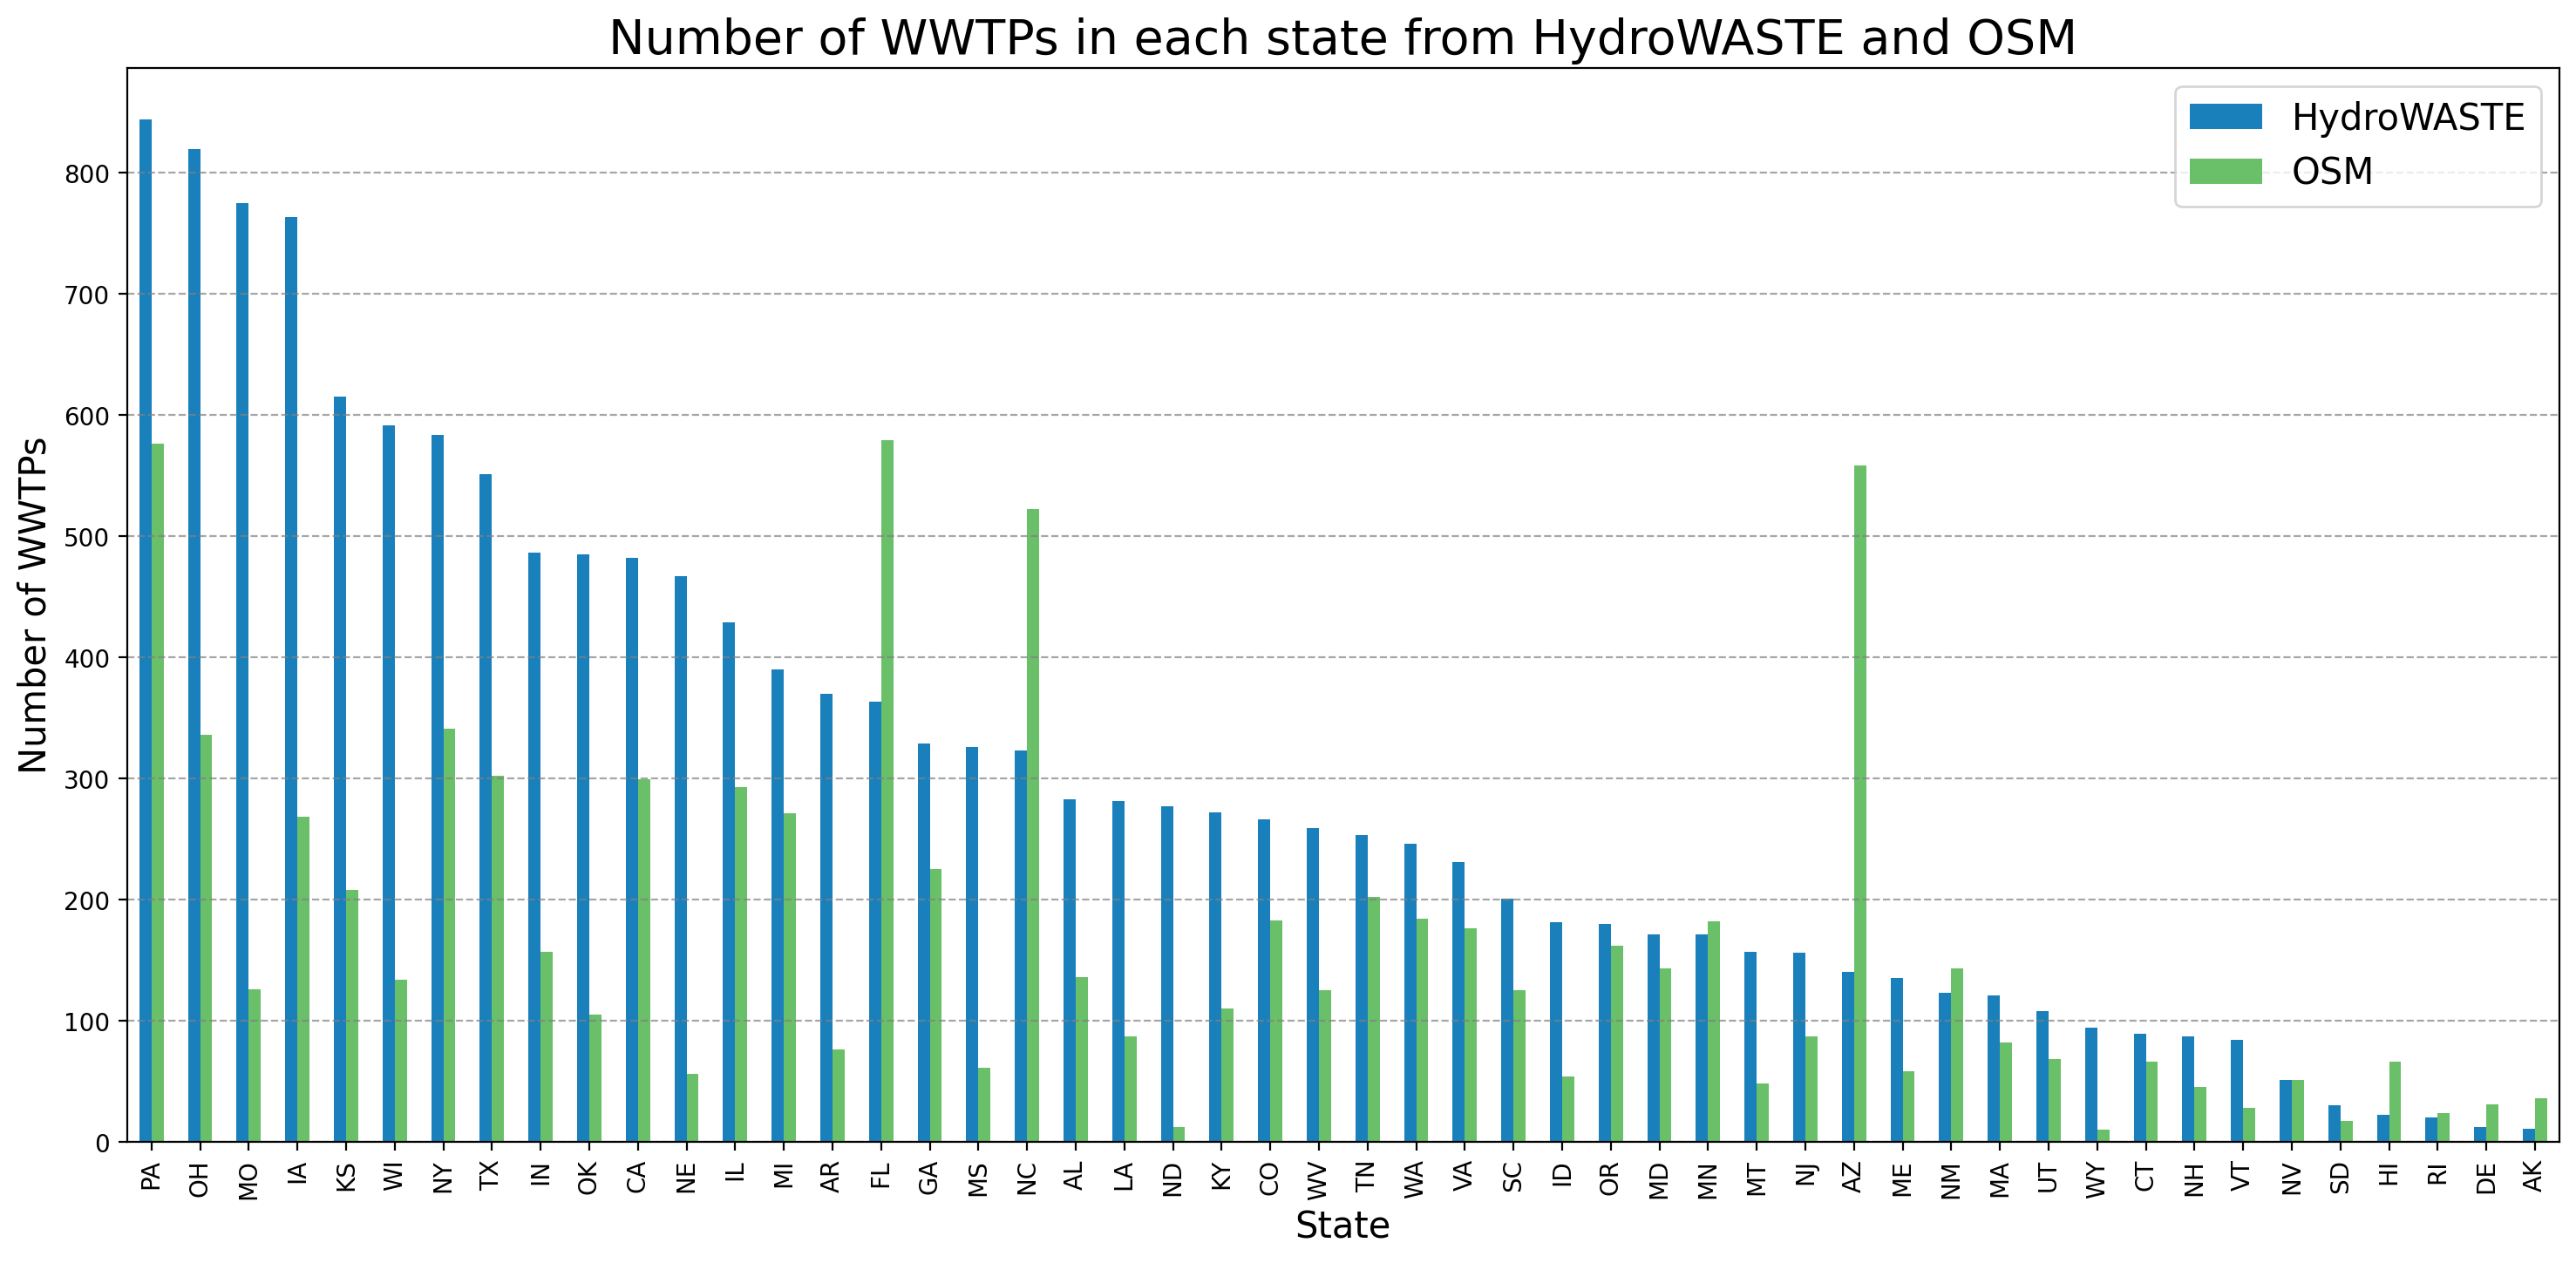

In [8]:
sorted_wwtp_num = utils.statewise_WWTP_count(
    hw_df=df_hw_us,
    target_df=osm_us,
    target_df_name="osm",
    state_name_abbrev_pair=state_name_abbrev_pair,
    hw_color=blue_color,
    target_color=green_color,
)

## Find the closest WWTP from OSM to each entry of HydroWaste (only in CA and TX)

In [9]:
osm_CA

,WWTP_name,geometry,osm_longitude,osm_latitude
0,Plant_24298754,"POLYGON ((-121.8093956 37.6930507, -121.805817...",-121.807618,37.691205
1,Plant_24396910,"POLYGON ((-121.7836023 36.8042341, -121.783634...",-121.780253,36.799902
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.2930951 37.8228457, -122.292380...",-122.295253,37.825121
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.4291394 33.9195675, -118.431621...",-118.430064,33.925741
4,Sunnyvale Water Pollution Control Plant,"POLYGON ((-122.018146 37.4191126, -122.017951 ...",-122.015265,37.418974
...,...,...,...,...
294,Plant_1118189719,"POLYGON ((-124.1959566 40.7680611, -124.194395...",-124.194542,40.765620
295,Riverside Water Quality Control Plant,"POLYGON ((-117.4643206 33.961609, -117.4643402...",-117.458295,33.962657
296,West County Wastewater - Water Quality & Resou...,"POLYGON ((-122.380263 37.9676487, -122.3802314...",-122.377169,37.964215
297,Plant_1180546479,"POLYGON ((-122.362376 38.394246, -122.3611974 ...",-122.360351,38.393626


In [12]:
osm_CA = utils.find_closest_point(
    source_df=osm_CA,
    target_df=df_hw_us,
    source_lat_col="osm_latitude",
    source_lon_col="osm_longitude",
    target_lat_col="hw_lat",
    target_lon_col="hw_lon",
)

osm_TX = utils.find_closest_point(
    source_df=osm_TX,
    target_df=df_hw_us,
    source_lat_col="osm_latitude",
    source_lon_col="osm_longitude",
    target_lat_col="hw_lat",
    target_lon_col="hw_lon",
)

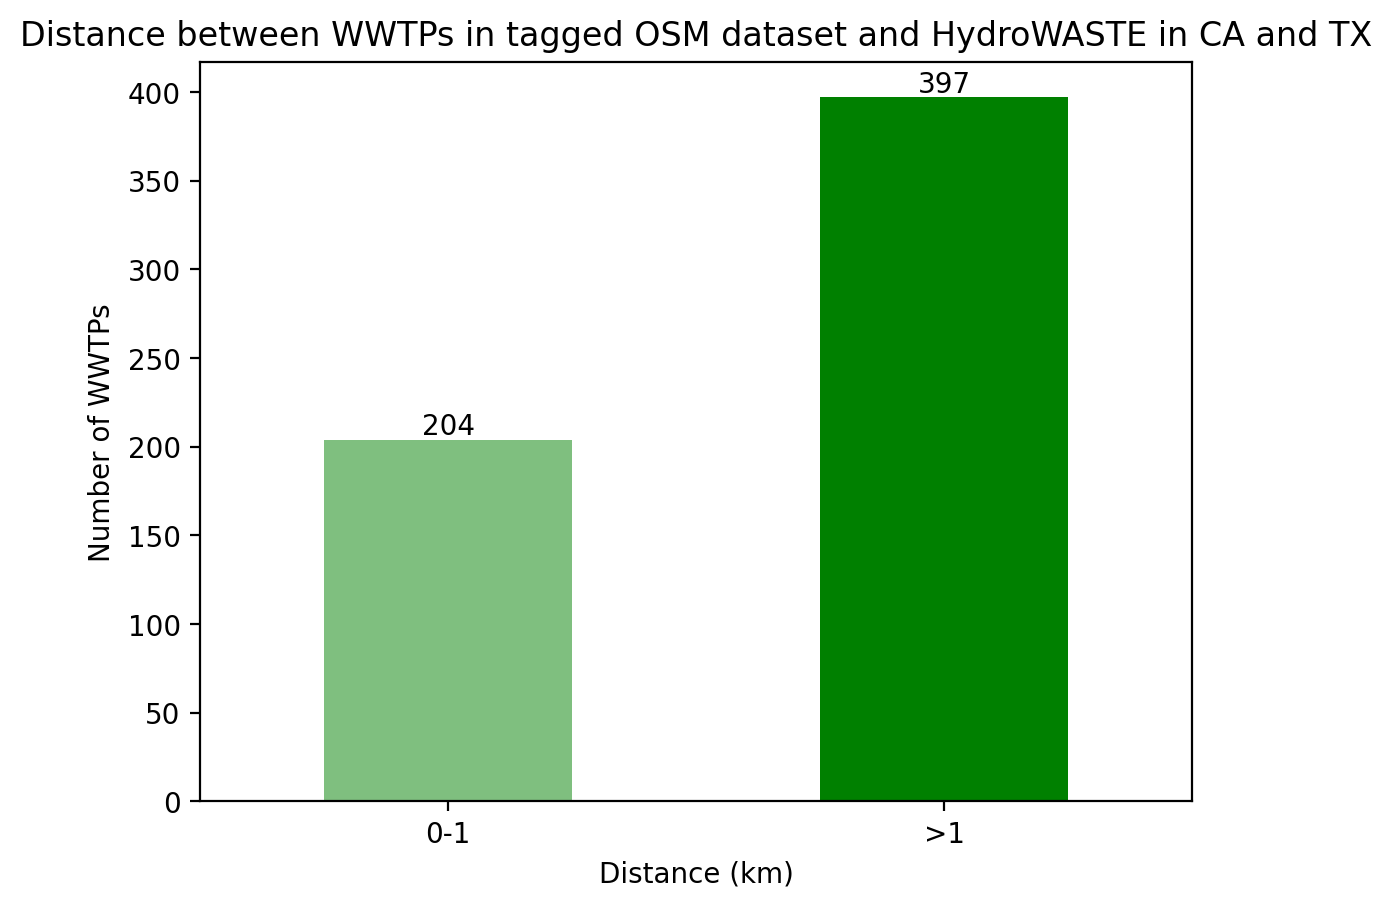

In [13]:
# plot the Distance between OSM and HydroWASTE in CA and TX
osm_CA_and_TX = pd.concat([osm_CA, osm_TX]).reset_index(drop=True)
bins = [0, 1, 1000]
labels = [
    "0-1",
    ">1",
]

# add a new column to the dataframe
osm_CA_and_TX["distance_bin"] = pd.cut(
    osm_CA_and_TX["distance"], bins=bins, labels=labels, right=True
)
# count each bin
osm_CA_and_TX["distance_bin"].value_counts().sort_values(ascending=True).plot(
    kind="bar", color="green"
)
# add title and labels
plt.title("Distance between WWTPs in tagged OSM dataset and HydroWASTE in CA and TX")
plt.xlabel("Distance (km)")
plt.ylabel("Number of WWTPs")
plt.xticks(rotation=0)
# add number labels
for i, v in enumerate(
    osm_CA_and_TX["distance_bin"].value_counts().sort_values(ascending=True)
):
    plt.text(i, v + 3, str(v), ha="center")
# for the first bar, alpha is 0.5
plt.gca().patches[0].set_alpha(0.5)
plt.show()